## Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2021-09-19 02:12:16.341385: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-19 02:12:16.341491: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Use TPU

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 50

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2021-09-19 02:12:21.896573: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-19 02:12:21.899346: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-19 02:12:21.899381: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-19 02:12:21.899406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5d23bf15f635): /proc/driver/nvidia/version does not exist
2021-09-19 02:12:21.903004: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-804df690eaa8afa72125e4d8ad5ff9997248d3a0aded04e1c44fb7f5


## List path of dataset

In [3]:
dataset_path = '../input/website-defacement/dataset/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

# Text-based Detection

## Prepare data

In [4]:
def prepare_data(name):
    if glob(dataset_path + f'text/defaced/{name}.txt'):
        path = dataset_path + f'text/defaced/{name}.txt'
        label = 1
    else:
        path = dataset_path + f'text/benign/{name}.txt'
        label = 0
    with open(path, 'r') as f:
        text = f.read()
    return (text, label)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=42)

print(len(X_train), len(X_valid), len(X_test))

  0%|          | 0/96234 [00:00<?, ?it/s]

57740 19247 19247


## Tokenizer

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)

MAXLEN = 128

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAXLEN)
y_train = np.array(y_train)

X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen=MAXLEN)
y_valid = np.array(y_valid)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAXLEN)
y_test = np.array(y_test)

## Create dataset

In [6]:
train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(100000)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid, y_valid))
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Learning rate, Plot history of model

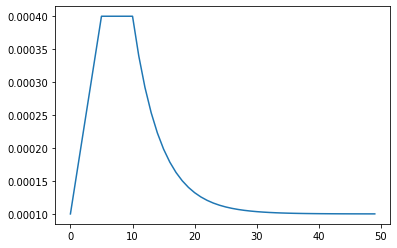

In [7]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=5,
         lr_sustain_epochs=5,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

## Create model

In [8]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.Conv1D(64, 5))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 64)           178523328 
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 64)           20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 178,544,002
Trainable params: 178,544,002
Non-trainable params: 0
_________________________________________________________________
None


## Train model

In [9]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-gru.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 178523328 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 39s - loss: 0.1571 - accuracy: 0.9322 - val_loss: 0.0835 - val_accuracy: 0.9671
Epoch 2/50
902/902 - 32s - loss: 0.0198 - accuracy: 0.9940 - val_loss: 0.0924 - val_accuracy: 0.9695
Epoch 3/50
902/902 - 32s - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0979 - val_accuracy: 0.9699
Epoch 4/50
902/902 - 32s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0987 - val_accuracy: 0.9701
Epoch 5/50
902/902 - 32s - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.1006 - val_accuracy: 0.9692
Epoch 6/50
902/902 - 32s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.1014 - val_accuracy: 0.9690
Epoch 7/50
902/902 - 32s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.1024 - val_accuracy: 0.9688
Epoch 8/50
902/902 - 32s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.1032 - val_accuracy: 0.9687
Epoch 9/50
902/902 - 32s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.1038 - val_accuracy: 0.9684
Epoch 10/50
902/902 - 32s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.1042 - val_accuracy: 0.9684


## Plot history

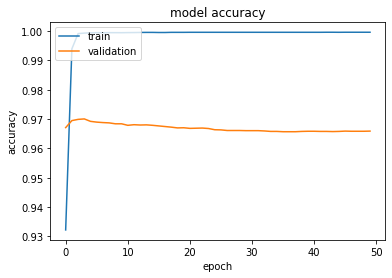

In [10]:
plot_hist(hist)

## Evaluate

In [11]:
with strategy.scope():
    model.load_weights('text-gru.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 5s 10ms/step
              precision    recall  f1-score   support

           0     0.9674    0.9797    0.9735     11446
           1     0.9697    0.9515    0.9605      7801

    accuracy                         0.9683     19247
   macro avg     0.9685    0.9656    0.9670     19247
weighted avg     0.9683    0.9683    0.9683     19247

[[11214   232]
 [  378  7423]]
      TPR       FPR       FNR   ROC AUC
   0.9515    0.0203    0.0485    0.9941


# Fusion with Image-based Detection

## Prepare image data

In [12]:
def prepare_data(name):
    if glob(dataset_path + f'image/defaced/{name}.png'):
        return (f'{GCS_DS_PATH}/dataset/image/defaced/{name}.png', 1)
    else:
        return (f'{GCS_DS_PATH}/dataset/image/benign/{name}.png', 0)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train, X_test, y_train, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=42)

print(len(X_train), len(X_valid), len(X_test))
print((y_test == y_test_).all())

  0%|          | 0/96234 [00:00<?, ?it/s]

57740 19247 19247
True


In [13]:
def decode_image(filename, label=None):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    if label is None:
        return image
    else:
        return image, label

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

## EfficientNet

## Load model

In [14]:
!pip install -q efficientnet
from efficientnet.tfkeras import EfficientNetB0

with strategy.scope():
    efn = EfficientNetB0(
        include_top=False, 
        weights='noisy-student', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(efn)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-efficientnet/weights.h5')

16703488/16696600 [==============================] - 0s 0us/step


## Evaluate image only model

In [15]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 609s 2s/step
              precision    recall  f1-score   support

           0     0.9509    0.9753    0.9630     11446
           1     0.9623    0.9262    0.9439      7801

    accuracy                         0.9554     19247
   macro avg     0.9566    0.9507    0.9534     19247
weighted avg     0.9555    0.9554    0.9552     19247

[[11163   283]
 [  576  7225]]
      TPR       FPR       FNR   ROC AUC
   0.9262    0.0247    0.0738    0.9902


## Fusion

In [16]:
y_prob = (y_prob_img + y_prob_txt) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9804    0.9900    0.9852     11446
           1     0.9852    0.9710    0.9781      7801

    accuracy                         0.9823     19247
   macro avg     0.9828    0.9805    0.9816     19247
weighted avg     0.9824    0.9823    0.9823     19247

[[11332   114]
 [  226  7575]]
      TPR       FPR       FNR   ROC AUC
   0.9710    0.0100    0.0290    0.9977


## Xception

## Load model

In [17]:
from tensorflow.keras.applications import Xception

with strategy.scope():
    net = Xception(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-xception/weights.h5')

83689472/83683744 [==============================] - 1s 0us/step


## Evaluate image only model

In [18]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 482s 2s/step
              precision    recall  f1-score   support

           0     0.9532    0.9696    0.9613     11446
           1     0.9542    0.9301    0.9420      7801

    accuracy                         0.9536     19247
   macro avg     0.9537    0.9499    0.9517     19247
weighted avg     0.9536    0.9536    0.9535     19247

[[11098   348]
 [  545  7256]]
      TPR       FPR       FNR   ROC AUC
   0.9301    0.0304    0.0699    0.9889


## Fusion

In [19]:
y_prob = (y_prob_img + y_prob_txt) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9768    0.9873    0.9821     11446
           1     0.9811    0.9656    0.9733      7801

    accuracy                         0.9785     19247
   macro avg     0.9790    0.9765    0.9777     19247
weighted avg     0.9786    0.9785    0.9785     19247

[[11301   145]
 [  268  7533]]
      TPR       FPR       FNR   ROC AUC
   0.9656    0.0127    0.0344    0.9974


## Inception

## Load model

In [20]:
from tensorflow.keras.applications import InceptionV3

with strategy.scope():
    net = InceptionV3(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-inception/weights.h5')

87916544/87910968 [==============================] - 1s 0us/step


## Evaluate image only model

In [21]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 474s 2s/step
              precision    recall  f1-score   support

           0     0.9051    0.9391    0.9218     11446
           1     0.9054    0.8555    0.8798      7801

    accuracy                         0.9052     19247
   macro avg     0.9053    0.8973    0.9008     19247
weighted avg     0.9052    0.9052    0.9048     19247

[[10749   697]
 [ 1127  6674]]
      TPR       FPR       FNR   ROC AUC
   0.8555    0.0609    0.1445    0.9632


## Fusion

In [22]:
y_prob = (y_prob_img + y_prob_txt) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9709    0.9854    0.9781     11446
           1     0.9781    0.9567    0.9673      7801

    accuracy                         0.9738     19247
   macro avg     0.9745    0.9710    0.9727     19247
weighted avg     0.9738    0.9738    0.9737     19247

[[11279   167]
 [  338  7463]]


## Image-LSTM

## Load model

In [23]:
def decode_image(filename, label=None):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_png(bits, channels=1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.reshape(image, (IMG_SIZE, IMG_SIZE))
    
    if label is None:
        return image
    else:
        return image, label

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [24]:
with strategy.scope():
    model = Sequential()
    model.add(L.Bidirectional(L.LSTM(units=64, return_sequences=True, dropout=0.2, 
                                     recurrent_dropout=0.2), input_shape=(IMG_SIZE, IMG_SIZE)))
    model.add(L.Bidirectional(L.LSTM(units=64, return_sequences=True, dropout=0.2, 
                                     recurrent_dropout=0.2)))
    model.add(L.Bidirectional(L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)))
    model.add(L.Dense(16, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-image-lstm/weights.h5')

## Evaluate image only model

In [25]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 472s 2s/step
              precision    recall  f1-score   support

           0     0.9102    0.9257    0.9179     11446
           1     0.8881    0.8660    0.8769      7801

    accuracy                         0.9015     19247
   macro avg     0.8992    0.8958    0.8974     19247
weighted avg     0.9013    0.9015    0.9013     19247

[[10595   851]
 [ 1045  6756]]
      TPR       FPR       FNR   ROC AUC
   0.8660    0.0743    0.1340    0.9635


## Fusion

In [26]:
y_prob = (y_prob_img + y_prob_txt) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9716    0.9834    0.9775     11446
           1     0.9752    0.9578    0.9664      7801

    accuracy                         0.9730     19247
   macro avg     0.9734    0.9706    0.9720     19247
weighted avg     0.9731    0.9730    0.9730     19247

[[11256   190]
 [  329  7472]]
